In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pip install torch torchvision torchaudio
%pip install datasets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import torch.nn as nn
import torch.utils.data
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import torchvision.utils as vutils
from datasets import load_dataset
from src.CustomTransforms import FromHxWxC_To_CxHxW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"pytorch running on {device}")

pytorch running on cuda


## Create PyTorch dataset from huggingface dataset

In [5]:
dataset = load_dataset("diffusers/pokemon-gpt4-captions")
dataset = dataset.with_format(type='torch', columns=['image', 'text'])
display(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})

In [6]:
from src.Dataloader import ImageHuggingfaceDataset

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],   # maps to [-1,1]
                         [0.5, 0.5, 0.5])
])
ds_train = ImageHuggingfaceDataset(dataset['train'], label='text', category='image', transform=transform)

In [7]:
example = ds_train[0]
print(example[0].shape)

torch.Size([3, 128, 128])


In [8]:
ds_train = ImageHuggingfaceDataset(dataset['train'], label='text', category='image', transform=transform)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=True, num_workers=0, drop_last=True)


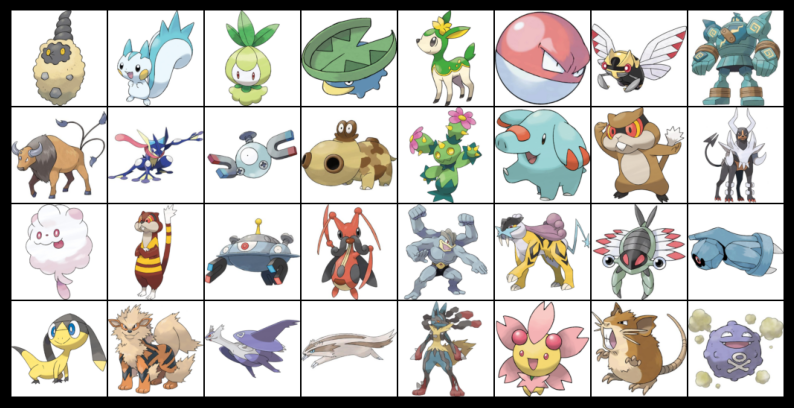

In [9]:
# Get a batch of images from the DataLoader
dataiter = iter(dl_train)
images, _ = next(dataiter)

# Create a grid of images
grid = vutils.make_grid(images, padding=2, normalize=True)

# Transpose the tensor from CxHxW to HxWxC
grid = np.transpose(grid, (1, 2, 0))

# Display the images
plt.figure(figsize=(10, 10))
plt.imshow(grid)
plt.axis('off')
plt.show()

### Istantiate generator and discriminator


In [10]:
from src.Model.Generator import Generator

nz = 100
image_size = 512
nc = 3
ngf = 64
generator = Generator(nz, ngf, nc).to(device)
generator.init_weights()

In [11]:
# test the generator inference
noise = torch.randn(64, nz, 1, 1, device=device)
fake = generator(noise)
print(fake.shape)

torch.Size([64, 3, 128, 128])


In [12]:
from src.Model.Discriminator import Discriminator

ndf = 64

discriminator = Discriminator(nc, ndf).to(device)
discriminator.init_weights()

In [13]:
# test the discriminator inference
output = discriminator(fake)
print(output.shape)

torch.Size([64, 1, 1, 1])


## Training the GAN

In [19]:
uses_sigmoid = any(isinstance(m, nn.Sigmoid) for m in discriminator.modules())
criterion = nn.BCELoss() if uses_sigmoid else nn.BCEWithLogitsLoss()

real_label_val = 0.9   # one-sided label smoothing
fake_label_val = 0.0
lr = 2e-4
beta1 = 0.5
beta2 = 0.999
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator.to(device)
discriminator.to(device)


Discriminator(
  (stage1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (stage2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (stage3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (stage4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (stage5): Sequential(
    (0): Conv2d

In [20]:
import os
import glob
# Check for existing checkpoints
checkpoint_dir = "checkpoints"
checkpoint_files = glob.glob(os.path.join(checkpoint_dir, "checkpoint_*.pt"))

if checkpoint_files:
    # Load the most recent checkpoint
    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
    print(f"Loading checkpoint: `{latest_checkpoint}`")

    checkpoint = torch.load(latest_checkpoint, map_location=device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

    print("Models loaded from checkpoint successfully")
else:
    # Initialize weights if no checkpoint exists
    generator.init_weights()
    discriminator.init_weights()
    print("No checkpoint found. Initialized models with random weights")

Loading checkpoint: `checkpoints\checkpoint_2026-01-08T11-24-00.381723.pt`
Models loaded from checkpoint successfully


C:\Users\WiZ\AppData\Local\Temp\ipykernel_22668\2130214723.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(latest_checkpoint, map_location=devic

In [21]:
# sample a batch and check sizes
batch = next(iter(dl_train))
real_images = batch[0].to(device)
bsize = real_images.size(0)
print("real_images.shape:", real_images.shape)  # expect (batch, 3, 128, 128)

# generate fake and check shape matches
nz = 100
noise = torch.randn(bsize, nz, 1, 1, device=device)
fake = generator(noise)
print("fake.shape:", fake.shape)  # should equal real_images.shape
assert fake.shape == real_images.shape, "Generator output shape must match real image shape (C,H,W). Adjust Generator or transforms."


real_images.shape: torch.Size([32, 3, 128, 128])
fake.shape: torch.Size([32, 3, 128, 128])


In [ ]:
img_list = []
G_losses = []
D_losses = []
num_epochs = 100
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dl_train, 0):
        discriminator.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label_val, dtype=torch.float, device=device)
        output = discriminator(real_cpu).view(-1)

        errD_real = criterion(output, label)

        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(fake_label_val)
        output_fake = discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output_fake, label)
        errD_fake.backward()
        D_G_z1 = output_fake.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        generator.zero_grad()
        label.fill_(real_label_val)
        output_fake_forG = discriminator(fake).view(-1)
        errG = criterion(output_fake_forG, label)
        errG.backward()
        optimizerG.step()
        D_G_z2 = output_fake_forG.mean().item()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dl_train),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        print(f"Loss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\tD(x): {D_x:.4f}\tD(G(z)) before: {D_G_z1:.4f}\tafter: {D_G_z2:.4f}")

        iters += 1

import os
import datetime
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

ts = datetime.datetime.now().isoformat(timespec='microseconds')
ts_safe = ts.replace(':', '-')
checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_{ts_safe}.pt")

torch.save({
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizerG_state_dict': optimizerG.state_dict(),
    'optimizerD_state_dict': optimizerD.state_dict(),
    'G_losses': G_losses,
    'D_losses': D_losses,
    'timestamp': ts
}, checkpoint_path)

print(f"Saved checkpoint: `{checkpoint_path}`")


Starting Training Loop...
[0/100][0/26]	Loss_D: 0.3844	Loss_G: 2.2299	D(x): 0.8431	D(G(z)): 0.0139 / 0.1115
Loss_D: 0.3844	Loss_G: 2.2299	D(x): 0.8431	D(G(z)) before: 0.0139	after: 0.1115
Loss_D: 0.9304	Loss_G: 9.1756	D(x): 0.9919	D(G(z)) before: 0.3079	after: 0.0001
Loss_D: 0.5941	Loss_G: 6.9452	D(x): 0.6304	D(G(z)) before: 0.0004	after: 0.0008
Loss_D: 0.3815	Loss_G: 5.9525	D(x): 0.9305	D(G(z)) before: 0.0050	after: 0.0032
Loss_D: 0.3822	Loss_G: 6.3572	D(x): 0.9456	D(G(z)) before: 0.0075	after: 0.0016
Loss_D: 0.3704	Loss_G: 5.3619	D(x): 0.8680	D(G(z)) before: 0.0080	after: 0.0052
Loss_D: 0.3630	Loss_G: 5.4298	D(x): 0.9069	D(G(z)) before: 0.0078	after: 0.0035
Loss_D: 0.4136	Loss_G: 4.1761	D(x): 0.8240	D(G(z)) before: 0.0105	after: 0.0162
Loss_D: 0.4178	Loss_G: 4.5065	D(x): 0.8896	D(G(z)) before: 0.0387	after: 0.0087
Loss_D: 0.4208	Loss_G: 5.4857	D(x): 0.9551	D(G(z)) before: 0.0377	after: 0.0027
Loss_D: 0.5536	Loss_G: 3.1520	D(x): 0.6454	D(G(z)) before: 0.0032	after: 0.0405
Loss_D: 0.54

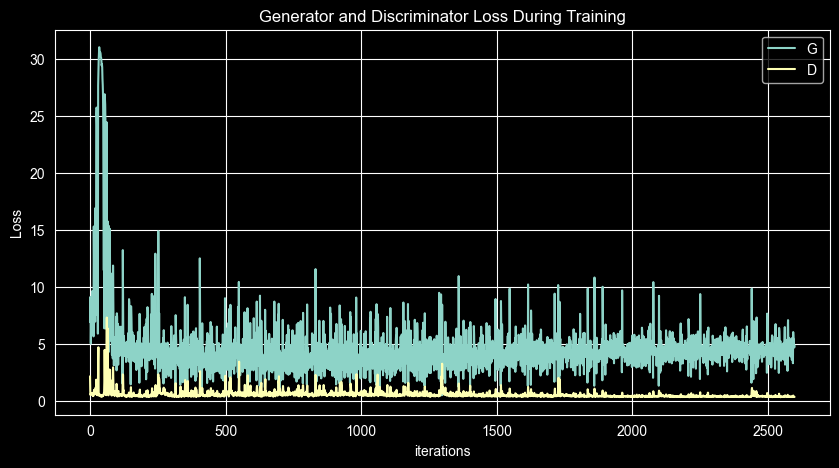

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

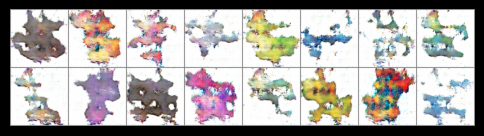

In [18]:
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

with torch.no_grad():
    sample = fake[:16].cpu()
# denormalize: x = x*0.5 + 0.5
grid = vutils.make_grid(sample, padding=2, normalize=False)
grid = grid * 0.5 + 0.5
grid = np.transpose(grid.numpy(), (1,2,0))
plt.figure(figsize=(6,6)); plt.imshow(grid); plt.axis('off'); plt.show()